## Assignment 1 - Classification


## Learning Outcomes


* Data exploration and pre-processing

* Develop a pipeline to carry out classification

* Compare different metrics and classifiers

The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using grid search.


In [1]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


**Questions (12 marks total)**

Q1.  Explore the credit card data set provided. You can also access it from the this link 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
(https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

The data is open for public use and no authorizations are required.

You will build a classification model for this default of credit card clients dataset.  The objective is to predict whether or not a credit card client will default for their payment in the next month.

Make sure you perform your analyses and answer the questions in sections below:

1. Data exploration:  ( 3 marks) 

    - Explore the data ( for example look at the data, plot graphs ( histogram, pair plots)
    
2. Data Preprocessing: (4 marks)

    - Make sure you build a full data pipeline ( ie., use the pipeline to apply transformers and estimators- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html )
    - Do you require any data pre-processing? Are all the features useful? (Use only raw features from this dataset, in other words, no need to create feature crosses or new features)
    - Set the random seed to 123 (For splitting or any other random algorithm)
    - Split data into training (80%) and testing (20%)
    - Use Cross-validation with 5-folds
    - For other parameters, use default

3. Classification: (5 marks)

    - Study the ROC Curve, decide threshold
    - Use 2 classifiers.
    
         a. Random Forest
            - tune only: n_estimators: {4, 5, 10, 20, 50}.  We will be running random forest model using GridSearchCV, determine the best hyperparameter for the given list of n_estimators {4, 5, 10, 20, 50}. n_estimators refers to the number of trees in the forest. We will use CV = 5 and the scoring to be the roc_auc (area under the curve)
          
       b. KNN Classfier 
            - tune only: n_neighbors: {3, 5, 10, 20}. You may perform similar GridSearchCV as in the previous exercise with a given list of n_neightbors. 
        
    - Which one performs better in the cross validation? Note down your observations and give comments.
    
You may refer to the documentation for RandomForests and KNN Classifiers, for the different parameters and options available in the scikit-learn library.
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



# Kelsey's Default Forecasiting Practice Overview
# 1. Data Exploration
    1.1 Data Load
    1.2 EDA
       1.2.1 Check data type,missing value,distribution: to determine how to group categorical, discrete, continuous variables
       1.2.2 Build different type of variables
       1.2.3 Correlation: Examine correlation between independent and dependent variable, and correlations among independent variables themselves.

        Check which independent variables have a high correlation with the dependent variable. Findings:
        - The PAY variables all show a strong correlation with the target label.
        - LIMIT_BAL has a strong negative correlation with the label.
        - The PAY_AMT variables also have a strong negative correlation with the label.
        - SEX, MARRIAGE, EDUCATION, and AGE show moderate correlations with the label.
        - BILL_AMT variables show some correlation, but BILL_AMT6 and BILL_AMT5 have correlations below 0.01.

        I examined the two features that show the strongest relationship with the target label.
            The higher the value of PAY_0, the more likely a client is to default.
            However, the behavior differs between PAY_0 ≤ 1 and PAY_0 > 1:
                When PAY_0 ≤ 1, clients with higher credit limits have a lower probability of default.
                When PAY_0 > 1, clients with higher credit limits are more likely to default.
**This suggests that clients can be clustered based on PAY_0 into different groups and trained with separate models, allowing the model to better capture their distinct behavioral patterns.**

# 2.Data Preprocessing
    2.1 data transform
        2.1.1 Numerical column transformer
        I choose Standardization over Normalization because:
        - Credit limits, bill amounts, payments have meaningful magnitudes. Outliers are informative.Standardization preserves relative distances
        - Standardization is more robust to outliers than normalization
        2.1.2 Categorical column transformer
**Discrete variables are categorical variables that have a natural order.**
**I did not scale discrete variables because scaling would produce fractional values (e.g., 1.3) that do not make sense for ordered categories and would create non-existent data points.**

        2.1.3 Put pipelines together
**There’s a cleaner way that keeps OneHotEncoder only once: do the EDUCATION recode as an upstream step on the full DataFrame, then run a single ColumnTransformer that one-hots all categoricals (including the now-grouped EDUCATION).**

        preprocess = Pipeline([
            ('group_edu', EducationGrouper()),
            ('ct', ColumnTransformer(transformers=[
                ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
                 education_vars + categorical_vars),
                ('cont_scale', StandardScaler(), continuous_vars),
                ('disc_pass', 'passthrough', discrete_vars)
            ], remainder='drop'))
        ])
    
    2.2 Train-test Split
    
    2.3 Fit and Transform
        2.3.1 Fit ONLY on training data to prevent data-leakage
        2.3.2 Check feature names after transformation
        2.3.3 Transform both training and test data
    
    2.4  Models - choose 4 models as below
        2.4.1 Display CV results for each model
            K nearest neighbors  mean accuracy:  79.275 % std:  0.0 %
            Random Forest Classifier  mean accuracy:  81.454 % std:  0.002 %
            XGBoost  mean accuracy:  81.071 % std:  0.003 %
            LogisticRegression  mean accuracy:  80.921 % std:  0.002 %
        2.4.2 Use SHAP explainer to improve data processing
**After identifying the best-performing model, I believe the forecasting results could be further improved through careful feature selection, as some features show only a weak correlation with the target label.To investigate feature importance, I conducted a SHAP analysis. The results suggest that the education and marriage variables could be refined. Some categories contain very few observations, so I plan to merge smaller categories and drop one category from each variable (i.e., apply one-hot encoding with drop='first') to simplify the model and reduce redundancy.**

# 3. Classifications
    3.1 Hyperparameter Tuning - CV
    3.2 Evaluation:Accuracy, Confusion Matrix, ROC curve
    3.2 Experiment ensemble Random Forest and XGBoost model
    3.3 Test different shreshold

# 4. Conclusions and Future Work


1.1 Data Load with index_col set to ID

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = None

In [4]:
df = pd.read_excel("default of credit card clients.xls", sheet_name = 0, skiprows= 1, header = 0,index_col='ID')

In [5]:
df.shape

(30000, 24)

In [6]:
df.sample(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
25666,40000,2,2,2,26,-1,0,0,0,-1,0,28991,24391,13600,0,44024,18697,1300,1000,0,22373,680,10000,0
16465,80000,2,3,1,59,0,0,0,0,0,0,75662,70073,53169,50875,50372,49470,3212,2106,2000,1603,1903,2006,0
22387,170000,2,1,2,30,2,2,2,2,2,2,155910,158819,161487,157577,168094,170922,6800,6500,0,13000,5500,1000,1
10150,200000,2,2,1,41,-2,-2,-2,-2,-2,-2,23570,735,0,0,0,0,742,0,0,0,0,0,1
8730,50000,1,2,1,43,0,0,0,0,0,0,8214,8034,9044,9225,9417,9617,1140,1150,331,341,356,330,0


In [7]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


1.2 EDA
1.2.1 Data type,missing value,distribution: to determine how to group
categorical, discrete, continuous variables

In [8]:
dftr=df.copy()
dftr.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [9]:
'''
check there is no variable with missing value
'''
dftr.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [10]:
#check the labels
'''
around 30% label is default,which is not considered skewed. 
'''
dftr['default payment next month'].value_counts()

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [11]:
#check not contimuous vars to confirm if they are discrete or category
dftr['LIMIT_BAL'].value_counts().sort_index()
'''
'LIMIT_BAL' should be continuous
'''

"\n'LIMIT_BAL' should be continuous\n"

In [12]:
dftr['LIMIT_BAL'].value_counts().sort_index()

LIMIT_BAL
10000       493
16000         2
20000      1976
30000      1610
40000       230
           ... 
750000        4
760000        1
780000        2
800000        2
1000000       1
Name: count, Length: 81, dtype: int64

In [13]:
dftr['MARRIAGE'].value_counts().sort_index()
#after encoding and drop first will become 3 columns

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [14]:
dftr['EDUCATION'].value_counts().sort_index()
#after grouping, encoding and drop first will become 3 columns

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [15]:
dftr['SEX'].value_counts().sort_index()
#will become 2 columns

SEX
1    11888
2    18112
Name: count, dtype: int64

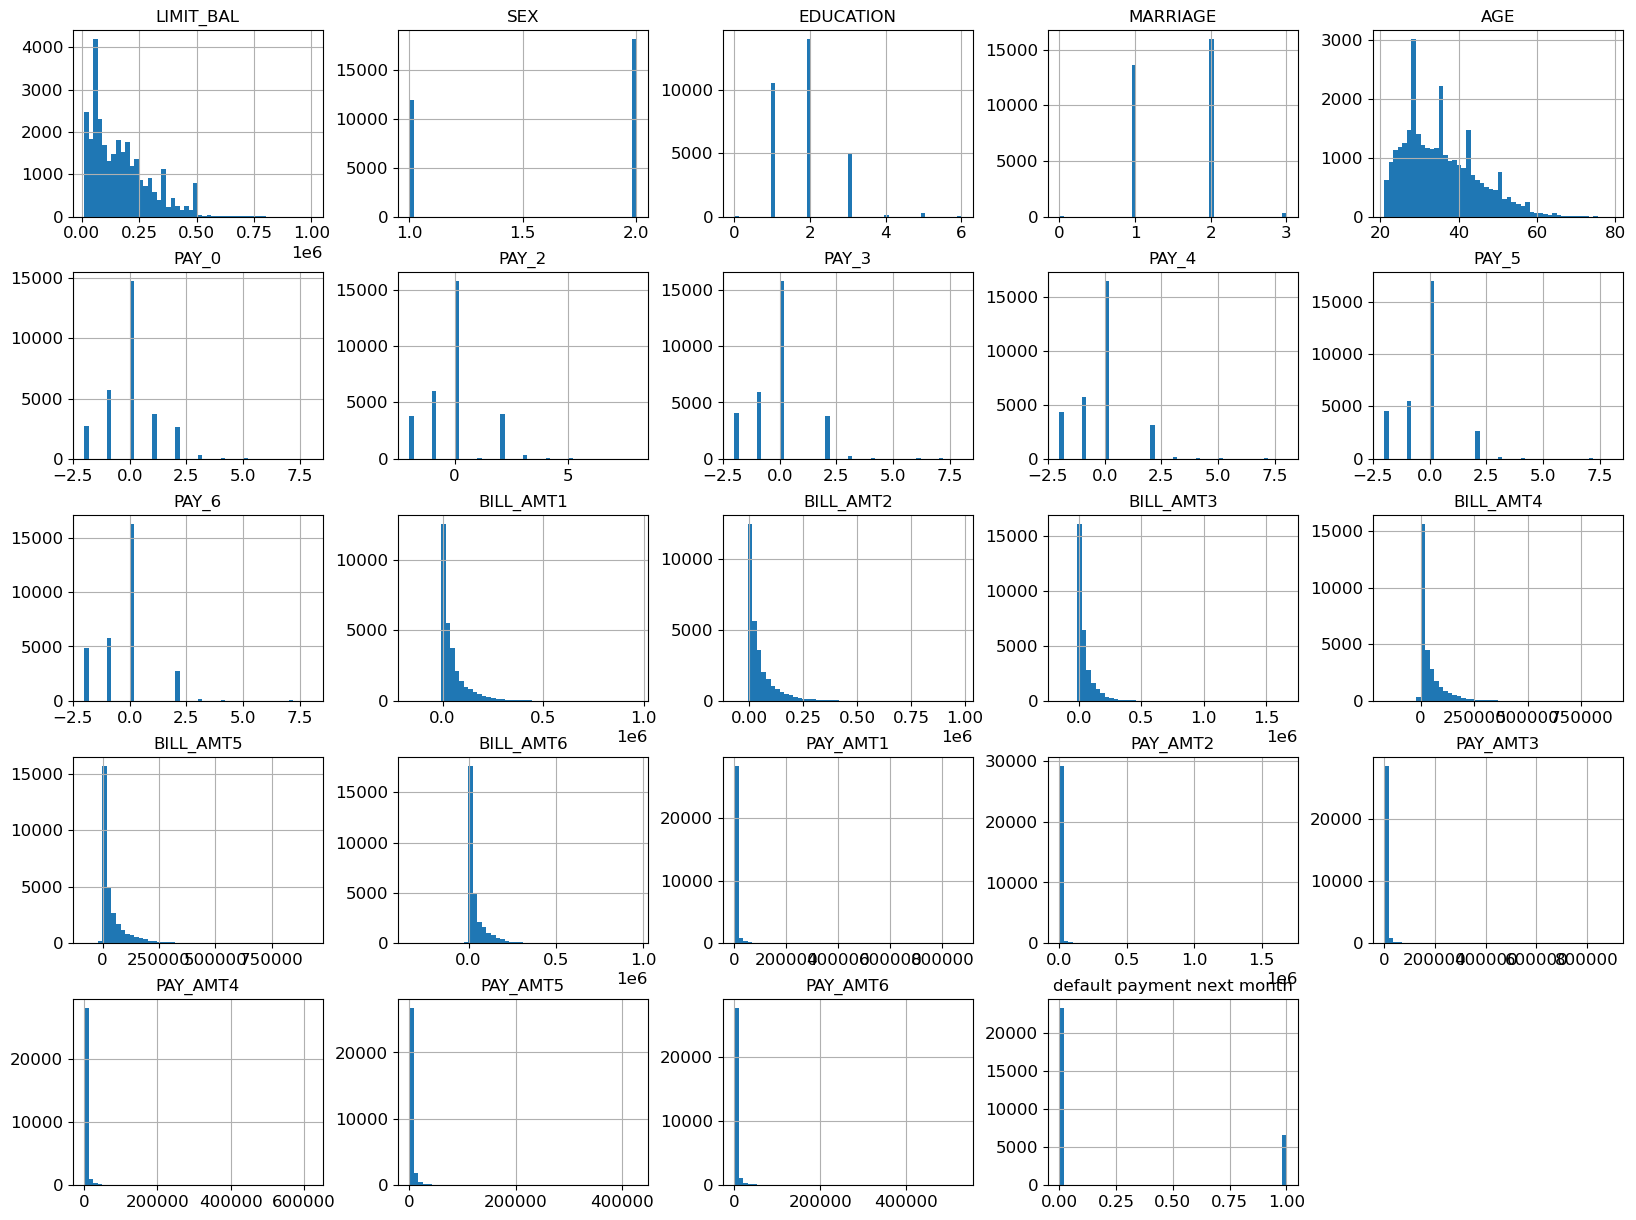

'\nLIMIT_BAL has strong negative correlation with label and has right skewed.\nIt might be helpful to log it \n'

In [16]:
#visualize distribution
dftr.hist(figsize=(20,15),bins=50)
plt.show()
'''
LIMIT_BAL has strong negative correlation with label and has right skewed.
It might be helpful to log it 
'''

Distribution examimnation show LIMIT_BAL data distribution right skewed. Log treatment will help the model. 

C:\Users\Kelsey\AppData\Local\Temp\ipykernel_19584\520119950.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dftr['log_LIMIT_BAL'])


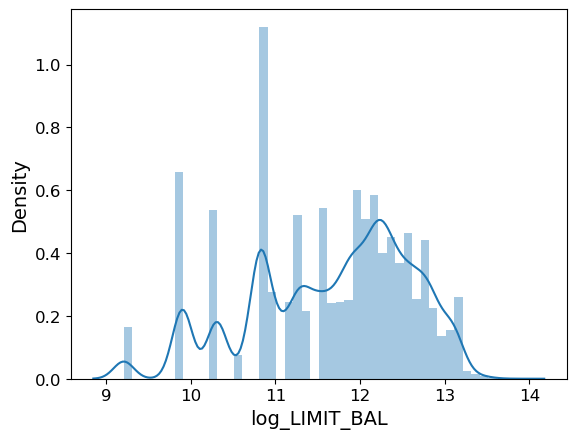

In [17]:
#optional treatment for the limit_bal
dftr['log_LIMIT_BAL'] = np.log(dftr['LIMIT_BAL'])
sns.distplot(dftr['log_LIMIT_BAL'])
# continuous_vars[2] = 'log_LIMIT_BAL'
plt.show()

1.2.2 Build different type of variables

In [18]:
dep_var=['default payment next month']
education_vars = ['EDUCATION']
categorical_vars=['SEX'	,'MARRIAGE'	]
discrete_vars = ['AGE','PAY_0',	'PAY_2',	'PAY_3',	'PAY_4',	'PAY_5',	'PAY_6']
continuous_vars = [i for i in dftr.columns if i not in dep_var+categorical_vars+discrete_vars+['log_LIMIT_BAL']+education_vars] 
'''
PAY since the status show relation with label when the status number increase, it means the higher number, the more likely customer default next month,
so PAY variables should be discrete_vars
'''

'\nPAY since the status show relation with label when the status number increase, it means the higher number, the more likely customer default next month,\nso PAY variables should be discrete_vars\n'

In [19]:
len(continuous_vars)

13

1.2.3 Correlation: 
Examine the correlation between each independent variable and the dependent variable, as well as the correlations among the independent variables themselves.

##Check which independent variables have a high correlation with the dependent variable. Findings:
Ordered by the strength of correlation:
###**The PAY variables all show a strong correlation with the target label.**
###**LIMIT_BAL has a strong negative correlation with the label.**
###**The PAY_AMT variables also have a strong negative correlation with the label.**
###**SEX, MARRIAGE, EDUCATION, and AGE show moderate correlations with the label.**
###**BILL_AMT variables show some correlation, but BILL_AMT6 and BILL_AMT5 have correlations below 0.01.**

In [20]:
dftr.corr()[dep_var[0]].sort_values(ascending=False)

default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDUCATION                     0.028006
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
MARRIAGE                     -0.024339
SEX                          -0.039961
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
log_LIMIT_BAL                -0.173571
Name: default payment nex

I examined the two features that show the strongest relationship with the target label.

**The higher the value of PAY_0, the more likely a client is to default.**
**However, the behavior differs between PAY_0 ≤ 1 and PAY_0 > 1:**

    When PAY_0 ≤ 1, clients with higher credit limits have a lower probability of default.
    When PAY_0 > 1, clients with higher credit limits are more likely to default.

**This suggests that clients can be clustered based on PAY_0 into different groups and trained with separate models, allowing the model to better capture their distinct behavioral patterns.**

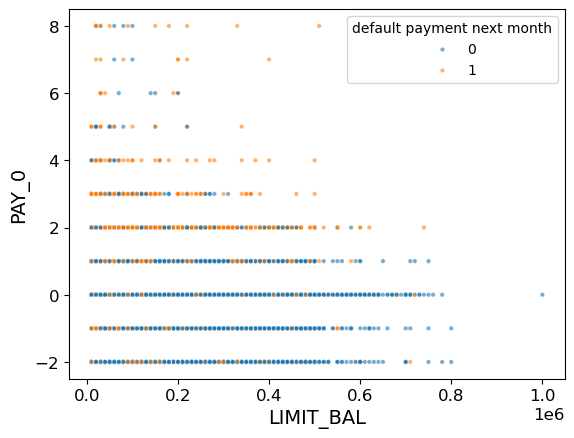

In [21]:
# PAY_0 vs LIMIT_BAL
sns.scatterplot(data=dftr, x='LIMIT_BAL', y='PAY_0', 
                hue='default payment next month', 
                s=10, alpha=0.6)
plt.show()

In [22]:
#check pairlot for categorical, discrete and continuous 

# sns.set(style='ticks')
# plt.figure(figsize=(20,20))
# sns.pairplot(data=dftr.loc[:,dep_var+categorical_vars+discrete_vars],hue=dep_var[0])
# plt.show()
'''
PAY_0 the higher the status number is the more likely the customer default next month
    Here is the difference status number's meaning: 
    -2: No consumption (no balance)
    -1: Paid duly (paid on time)
     0: Use of revolving credit (paid minimum amount)
     1: Payment delay for 1 month
     2: Payment delay for 2 months
     3: Payment delay for 3 months
     4: Payment delay for 4 months
     5: Payment delay for 5 months
     6: Payment delay for 6 months
     7: Payment delay for 7 months
     8: Payment delay for 8 months
     9: Payment delay for 9 months and above
LIMIT_BAL the lower the number is the more likely the curtomer default next month
    LIMIT_BAL represents the credit limit (maximum amount of credit available) for the client.
'''

"\nPAY_0 the higher the status number is the more likely the customer default next month\n    Here is the difference status number's meaning: \n    -2: No consumption (no balance)\n    -1: Paid duly (paid on time)\n     0: Use of revolving credit (paid minimum amount)\n     1: Payment delay for 1 month\n     2: Payment delay for 2 months\n     3: Payment delay for 3 months\n     4: Payment delay for 4 months\n     5: Payment delay for 5 months\n     6: Payment delay for 6 months\n     7: Payment delay for 7 months\n     8: Payment delay for 8 months\n     9: Payment delay for 9 months and above\nLIMIT_BAL the lower the number is the more likely the curtomer default next month\n    LIMIT_BAL represents the credit limit (maximum amount of credit available) for the client.\n"

In [23]:
# sns.set(style='ticks')
# plt.figure(figsize=(20,20))
# sns.pairplot(data=dftr.loc[:,dep_var+continuous_vars],hue=dep_var[0])
# plt.show()
'''
PAY_AMT the lower the number the more likely the customer will default next month
    PAY_AMT variables represent the amount of previous payment made in each month.
'''

'\nPAY_AMT the lower the number the more likely the customer will default next month\n    PAY_AMT variables represent the amount of previous payment made in each month.\n'

# 2.Data Preprocessing
Principles:
Features should not have any missing values.--> already no missing values
All features must be numerical. --> already all numerical
Features should have the same or similar scales (in particular, range and expected value). -->need scales
Category variable such as 'SEX','EDUCATION','MARRIAGE' --> might need one-hot encoding


In [24]:
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

Pipeline Design Problem Summary

I want first transform EDUCATION (via edutr) into grouped values (1, 2, 3 → themselves; others → 0).

Then I want to one-hot encode that transformed version, just like other categorical columns.

But in my pipeline, EDUCATION is included both in the custom transformer and the categorical pipeline, so it’s processed twice.

# 2.2 data transform
# 2.2.1 Numerical column transformer

1 Numerical column transformer - Standardize 

I choose Standardization over Normalization because:
1. Credit limits, bill amounts, payments have meaningful magnitudes. Outliers are informative.Standardization preserves relative distances
2. Standardization is more robust to outliers than normalization


In [25]:
#For single transformations, I don't need a Pipeline:
num_transformers = [('num', StandardScaler(), continuous_vars)]
'''
don't standardize discrete_vars
'''

"\ndon't standardize discrete_vars\n"

# 2.2.2 Categorical column transformer


Leaning from data processing steps: 
1.Each transformer should be a tuple! so don't omit the () in cat_transformers=[('cat',cat_pipe,categorical_vars)]
2.Use drop parameter in OneHotEncoder to Drop first category to avoid multicollinearity. 
By default, OneHotEncoder doesn't automatically drop one category - it creates all dummy variables. 
3.I was make mistake as edu_group_step=('edugr',edu_group_transformer()). 
I am trying to call the FunctionTransformer object with parentheses () when it should be passed as the object itself.
correct form edu_group_step=('edugr',edu_group_transformer)
4.FunctionTransformer doesn't automatically have the get_feature_names_out() method. I need to provide it explicitly. Here are a solution:
edu_group_transformer=FunctionTransformer(func=edutr,feature_names_out='one-to-one' )
5.My ColumnTransformer has:
cat_transformers: processes education_vars and categorical_vars
num_transformers: processes continuous_vars
But there's no transformer for discrete_vars, so they get dropped by default!
Use remainder='passthrough' (Quick Fix) ct = ColumnTransformer(transformers=cat_transformers + num_transformers,remainder='passthrough')


In [26]:
#Function to merge less common education categories into broader groups
def edutr(x):
    return x.map(lambda x: x if x in [1, 2, 3] else 0)

In [27]:

edu_group_transformer=FunctionTransformer(func=edutr,feature_names_out='one-to-one' )
edu_group_step=('edugr',edu_group_transformer)
edu_cat_ohe_step = ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first' ))
edu_steps=[edu_group_step,edu_cat_ohe_step]
edu_pipe=Pipeline(edu_steps)
edu_transformers = [('edu', edu_pipe, education_vars)]

cat_transformers = [('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first' ), categorical_vars)]

In [28]:
# 2.2.3 Put pipelines together.
ct = ColumnTransformer(transformers=edu_transformers+cat_transformers + num_transformers,remainder='passthrough')
'''
v3 add remainder='passthrough' for discrete_vars
'''

"\nv3 add remainder='passthrough' for discrete_vars\n"

**Alternative way from Delina - use an upstream step on the full DataFrame**
There’s a cleaner way that keeps OneHotEncoder only once: do the EDUCATION recode as an upstream step on the full DataFrame, then run a single ColumnTransformer that one-hots all categoricals (including the now-grouped EDUCATION).

Heres an example with a custom transformer:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class EducationGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        X = X.copy()
        X['EDUCATION'] = X['EDUCATION'].where(X['EDUCATION'].isin([1,2,3]), 0)
        return X

dep_var = ['default payment next month']
education_vars = ['EDUCATION']
categorical_vars = ['SEX', 'MARRIAGE']
discrete_vars = ['AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
continuous_vars = [c for c in dftr.columns 
                   if c not in dep_var + categorical_vars + discrete_vars + ['log_LIMIT_BAL'] + education_vars]

preprocess = Pipeline([
    ('group_edu', EducationGrouper()),
    ('ct', ColumnTransformer(transformers=[
        ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
         education_vars + categorical_vars),
        ('cont_scale', StandardScaler(), continuous_vars),
        ('disc_pass', 'passthrough', discrete_vars)
    ], remainder='drop'))
])

There's a data leakage issue in my v2 code. 
I am fitting the transformer on the entire dataset before splitting, 
which means information from the test set is influencing my training transformations. Change the approach as below

In [29]:
# 2.3 Train-test Split
# First, split the data
X = dftr[categorical_vars + discrete_vars + continuous_vars + education_vars]
y = dftr[['default payment next month']].values

X_train_o, X_test_o, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
print(X_train_o.shape, X_test_o.shape, y_train.shape, y_test.shape)

(24000, 23) (6000, 23) (24000, 1) (6000, 1)


In [30]:
# 2.4 Fit and Transform
# 2.4.1 Fit ONLY on training data to prevent data leakage
ct.fit(X_train_o)

C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('edu',
                                 Pipeline(steps=[('edugr',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function edutr at 0x00000205B0069F80>)),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['EDUCATION']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['SEX', 'MARRIAGE']),
                                ('num', StandardScaler(),
                                 ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6'])])

In [31]:
# 2.4.2 Check feature names after transformation
feature_names = ct.get_feature_names_out()
print(feature_names)

['edu__EDUCATION_1' 'edu__EDUCATION_2' 'edu__EDUCATION_3' 'cat__SEX_2'
 'cat__MARRIAGE_1' 'cat__MARRIAGE_2' 'cat__MARRIAGE_3' 'num__LIMIT_BAL'
 'num__BILL_AMT1' 'num__BILL_AMT2' 'num__BILL_AMT3' 'num__BILL_AMT4'
 'num__BILL_AMT5' 'num__BILL_AMT6' 'num__PAY_AMT1' 'num__PAY_AMT2'
 'num__PAY_AMT3' 'num__PAY_AMT4' 'num__PAY_AMT5' 'num__PAY_AMT6'
 'remainder__AGE' 'remainder__PAY_0' 'remainder__PAY_2' 'remainder__PAY_3'
 'remainder__PAY_4' 'remainder__PAY_5' 'remainder__PAY_6']


In [32]:
# 2.4.3 Transform both training and test data
X_train = ct.transform(X_train_o)
X_test = ct.transform(X_test_o)

In [33]:
print(X_train.shape, X_test.shape)

(24000, 27) (6000, 27)


In [34]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [35]:
# 2.5  Models
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [36]:
# 2.5.1 function to display CV results for each model
# classifiers = [
#     knnc(),
#     RandomForestClassifier(),
#     XGBClassifier(),
#     LogisticRegression()
# ]
# classifier_names = [
#     'K nearest neighbors',
#     'Random Forest Classifier',
#     'XGBoost',
#     'LogisticRegression'
# ]
# for clf, clf_name in zip(classifiers, classifier_names):
#     cv_scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=5)   
    
#     print(clf_name, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

'''
Random Forest Classifier perform the best
'''

K nearest neighbors  mean accuracy:  79.275 % std:  0.0 %
Random Forest Classifier  mean accuracy:  81.604 % std:  0.003 %
XGBoost  mean accuracy:  81.071 % std:  0.003 %


C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

LogisticRegression  mean accuracy:  80.921 % std:  0.002 %


C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

'\nRandom Forest Classifier perform the best\n'

In [37]:
# 2.5.1 function to display CV Training & Validation Scores for each model
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

classifiers = [
    knnc(),
    RandomForestClassifier(),
    XGBClassifier(),
    LogisticRegression()
]
classifier_names = [
    'K nearest neighbors',
    'Random Forest Classifier', 
    'XGBoost',
    'LogisticRegression'
]

print("Model Comparison with Training & Validation Scores")
print("=" * 70)

for clf, clf_name in zip(classifiers, classifier_names):
    # Use cross_validate instead of cross_val_score to get both scores
    cv_results = cross_validate(
        clf, 
        X_train, 
        np.ravel(y_train), 
        cv=5,
        return_train_score=True,  # This gives training scores
        scoring='accuracy'
    )
    
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    train_mean = round(train_scores.mean() * 100, 3)
    train_std = round(train_scores.std() * 100, 3)
    test_mean = round(test_scores.mean() * 100, 3) 
    test_std = round(test_scores.std() * 100, 3)
    gap = round((train_scores.mean() - test_scores.mean()) * 100, 3)
    
    print(f"{clf_name:25} | Train: {train_mean:6}% ± {train_std:5}% | "
          f"Test: {test_mean:6}% ± {test_std:5}% | Gap: {gap:5}%")

Model Comparison with Training & Validation Scores
K nearest neighbors       | Train:  84.22% ± 0.121% | Test: 79.275% ± 0.157% | Gap: 4.945%
Random Forest Classifier  | Train: 99.942% ± 0.013% | Test: 81.467% ± 0.501% | Gap: 18.475%
XGBoost                   | Train: 90.293% ± 0.194% | Test: 81.071% ± 0.509% | Gap: 9.222%


C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

LogisticRegression        | Train: 81.019% ± 0.138% | Test: 80.921% ± 0.443% | Gap: 0.098%


C:\Users\Kelsey\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Random Forest Overfitting: The Random Forest model appears to be overfitting, as indicated by the large discrepancy between the training and validation scores. If I introduce regularization by tuning hyperparameters like max_depth to reduce this overfitting, what impact would you expect on the model's performance on the final test set?

    - No, the test results will likely change, and ideally, improve.
    - The Goal of Regularization: The purpose of reducing max_depth or adding other regularization is to make the model simpler and less specialized to the noise in the training data. This should cause the training score to drop slightly, but the validation (and test) score should increase as the model becomes better at generalizing to unseen data.
    
    - The Outcome: You are trading a high, overly-optimistic training score for a more robust and reliable validation/test score. A model that generalizes better is almost always more valuable.

- Defining the "Gap": Is there a general rule of thumb for what size gap between training and validation scores is considered problematic?
    
    - There is no universal threshold (e.g., "a 5% gap is bad"). It depends on the context, but here’s how to think about it:
    
    - Relative, Not Absolute: Look at the gap relative to the scores themselves. A 99% training score and a 98% validation score is a tiny, usually negligible gap. A 99% training score and an 85% validation score is a massive red flag for overfitting.
    
    - Context is Key: In a very complex problem with noisy data, a larger gap might be expected. For a simple, clean dataset, even a small gap could be a concern.
    
    - The Best Indicator: The most important sign of overfitting is not just the size of the gap, but the trend. If your validation score stops improving or starts getting worse while your training score continues to climb, you are definitively overfitting.

- Model Selection: Since the overfitted model still achieves a good test score, would you advise against using it? I'm wondering about the potential downsides of deploying a model that overfits.

    - This is risky and generally not recommended.
    
    - The Test Set is a Snapshot: Your test score is based on a single, static set of data. An overfitted model is brittle and may perform poorly on new, slightly different data from the real world. It has memorized the training set rather than learning the underlying pattern.
    
    - Future Performance: The model's performance is likely to degrade over time as it encounters data that doesn't match the specific noise it learned from the training set.
    
    - The Better Alternative: A model that does not overfit (one with a smaller gap between training and validation scores) will almost certainly be more reliable and stable in production, even if its current test score is slightly lower. It's a safer long-term bet.

# 2.5.2 Use SHAP explainer to improve data processing

After identifying the best-performing model, I believe the forecasting results could be further improved through careful feature selection, as some features show only a weak correlation with the target label.

To investigate feature importance, I conducted a SHAP analysis. The results suggest that the education and marriage variables could be refined. Some categories contain very few observations, so I plan to merge smaller categories and drop one category from each variable (i.e., apply one-hot encoding with drop='first') to simplify the model and reduce redundancy.

EDUCATION

    0       14 - merge to other
    1    10585
    2    14030
    3     4917
    4      123 - merge to other
    5      280 - merge to other
    6       51 - merge to other


In [38]:
#fit a model for SHAP 
final_model_rfor = RandomForestClassifier().fit(X_train, np.ravel(y_train))

In [39]:
# Create SHAP explainer
import shap
# explainer = shap.TreeExplainer(final_model_rfor)  # For tree-based models
# shap_values = explainer.shap_values(X_test)

In [40]:
# shap_values_positive = shap_values[:, :, 1] 
# shap_df = pd.DataFrame(shap_values_positive, columns=feature_names)
# # Get a single SHAP importance value for each feature
# shap_importance = np.abs(shap_values_positive).mean(axis=0)

# # Create a simple Series
# shap_series = pd.Series(shap_importance, index=feature_names).sort_values(ascending=False)

# print("Single SHAP importance value for each feature:")
# print(shap_series)

#3. Classifications

# 3.1 Hyperparameter Tuning - CV

In [41]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define parameter grids
rf_param_grid = {
    'n_estimators': [4, 5, 10, 20, 50],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'n_estimators': [4, 5, 10, 20, 50],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' works only with certain solvers
    'solver': ['lbfgs', 'liblinear'],  # 'liblinear' works for small data
    'max_iter': [200, 500]
}

# Perform GridSearch for each model
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123),
    param_grid=rf_param_grid,
    scoring='accuracy',  # use accuracy since this is classification
    cv=5,
    n_jobs=-1
)

xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

logreg_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=123),
    param_grid=logreg_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# FIT THE MODELS
print("Fitting Random Forest...")
rf_grid_search.fit(X_train, np.ravel(y_train))

print("Fitting XGBoost...")
xgb_grid_search.fit(X_train, np.ravel(y_train))

print("Fitting Logistic Regression...")
logreg_grid_search.fit(X_train, np.ravel(y_train))

# Get best models
final_model_rf = rf_grid_search.best_estimator_
final_model_xgb = xgb_grid_search.best_estimator_
final_model_logreg = logreg_grid_search.best_estimator_

# Display best params
print("\nBest Parameters:")
print("Random Forest:", rf_grid_search.best_params_)
print("XGBoost:", xgb_grid_search.best_params_)
print("Logistic Regression:", logreg_grid_search.best_params_)

Fitting Random Forest...
Fitting XGBoost...


C:\Users\Kelsey\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting Logistic Regression...

Best Parameters:
Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Logistic Regression: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}


# 3.2 Evaluation:Accuracy, Confusion Matrix, ROC curve
I hope to test XGBoost because I was curious why it is widely used as the final model in many forecasting applications. I compared it with another tree-based model (Random Forest) and a pure regression model (Logistic Regression Classifier) to understand their performance differences.

## Results:
**Logistic Regression Classifier**
**The logistic regression model shows no overfitting and is very stable. However, its accuracy is the lowest among the three models because its linear nature cannot effectively capture the non-linear patterns in the data.**
    CV mean accuracy: 81.05% ± 0.41%
    Train accuracy: 81.07%
    Test accuracy: 81.52%
**Random Forest Classifier**
**The random forest model shows slight overfitting, as the training accuracy is about 4% higher than the test accuracy. With more data, this gap could be reduced. The model remains stable and performs better than logistic regression but slightly worse than XGBoost.**
    Random Forest CV mean accuracy: 81.91% ± 0.39%
    Random Forest Train Accuracy: 85.17%
    Random Forest Test Accuracy: 82.22%
**XGBoost Classifier**
**The XGBoost model is stable, with very close training and testing accuracy, indicating minimal overfitting. It also achieves the highest accuracy among the three models.**
    XGBoost CV mean accuracy: 82.11% ± 0.50%
    XGBoost Train Accuracy: 82.31%
    XGBoost Test Accuracy: 82.35%

## Limitations and Threshold Adjustment

**About 30% of the labels are positive (default payments).All models perform well in predicting non-defaults (negative labels) but are limited in detecting defaults (positive labels).**

If I aim for 70% recall — meaning I want to correctly identify 70% of all default payments — I would need to lower the threshold to 0.187.
At this threshold, precision drops to 40%, which means 40% of the predicted defaults are actually non-defaults, a high cost for practical use.

Therefore, I keep the default 0.5 probability threshold, accepting lower recall but lower precision.

    Threshold achieving ~70% recall: 0.187
    Precision: 40.42%
    Recall: 70.02%

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, np.ravel(y_train), cv=5)
    print(f"{name} CV mean accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
    
    # Fit and predict
    model.fit(X_train, np.ravel(y_train))
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    print(f"{name} Train Accuracy: {accuracy_score(y_train, y_train_pred)*100:.2f}%")
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_test_pred)*100:.2f}%")
    print("-" * 50)
    
    # ====== Confusion Matrix ======
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGn", cbar=False)
    plt.title(f"{name} - Confusion Matrix (Test Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ====== ROC Curve ======
    if hasattr(model, "predict_proba"):  # only models that support probabilities
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)

        # Find the index of threshold closest to 0.5
        close_05 = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr[close_05 + 1], tpr[close_05 + 1], 'o',
                 markersize=10, fillstyle="none", c='k', mew=2,
                 label="threshold = 0.5")

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} - ROC Curve")
        plt.legend(loc=4)
        plt.show()


Random Forest CV mean accuracy: 81.91% ± 0.39%
Random Forest Train Accuracy: 85.17%
Random Forest Test Accuracy: 82.22%
--------------------------------------------------


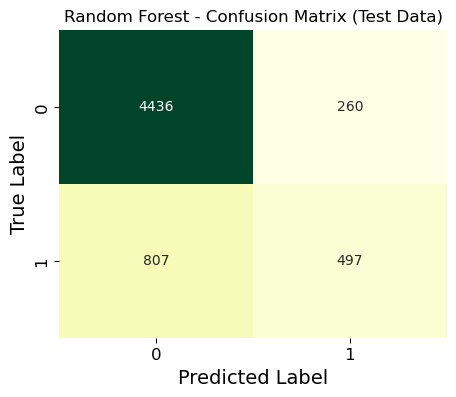

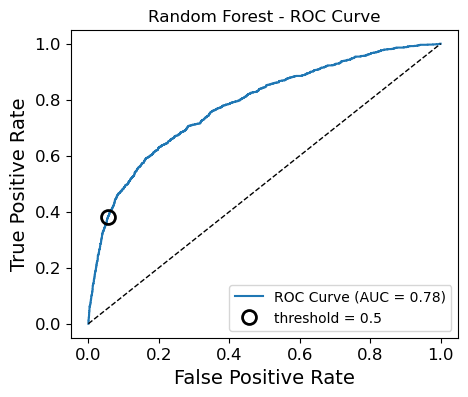

C:\Users\Kelsey\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Kelsey\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Kelsey\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Kelsey\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

XGBoost CV mean accuracy: 82.11% ± 0.50%
XGBoost Train Accuracy: 82.31%
XGBoost Test Accuracy: 82.35%
--------------------------------------------------


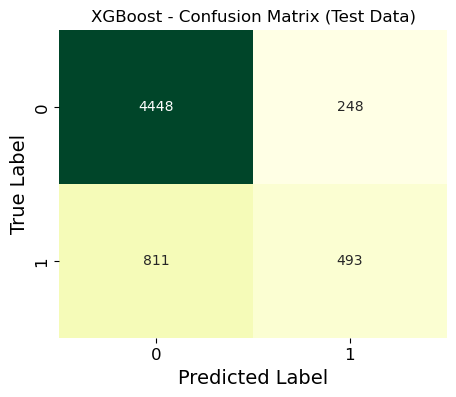

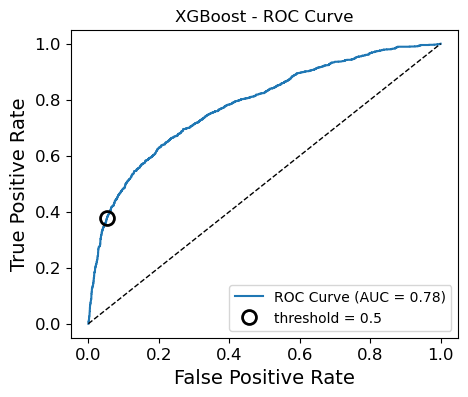

Logistic Regression CV mean accuracy: 81.05% ± 0.41%
Logistic Regression Train Accuracy: 81.07%
Logistic Regression Test Accuracy: 81.52%
--------------------------------------------------


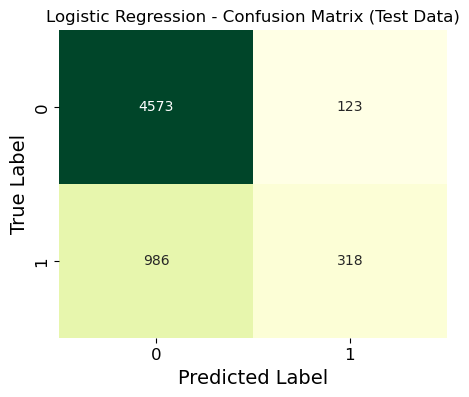

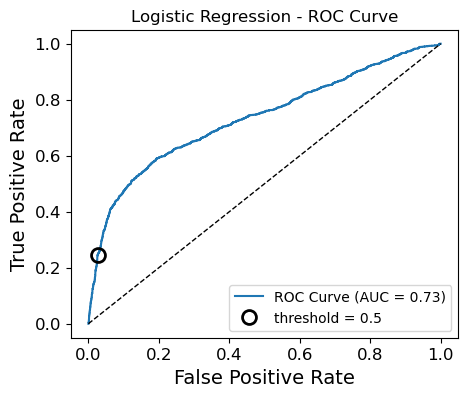

In [43]:
evaluate_model(final_model_rf, X_train, y_train, X_test, y_test, "Random Forest")
evaluate_model(final_model_xgb, X_train, y_train, X_test, y_test, "XGBoost")
evaluate_model(final_model_logreg, X_train, y_train, X_test, y_test, "Logistic Regression")


In [44]:
#3.2 ensemble Random Forest and XGBoost models: But it didn't improve performance and generalization.So I skip this in the final model
import numpy as np
from sklearn.metrics import accuracy_score

# Predict probabilities
rf_probs = final_model_rf.predict_proba(X_test)
xgb_probs = final_model_xgb.predict_proba(X_test)

# Average the probabilities
avg_probs = (rf_probs + xgb_probs) / 2

# Take the class with the highest averaged probability
y_pred_ensemble = np.argmax(avg_probs, axis=1)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Test Accuracy: {accuracy*100:.2f}%")

Ensemble Test Accuracy: 82.27%


Threshold that achieves ~70% recall: 0.187
Actual recall at this threshold: 70.02%
Precision: 40.42%
Recall: 70.02%


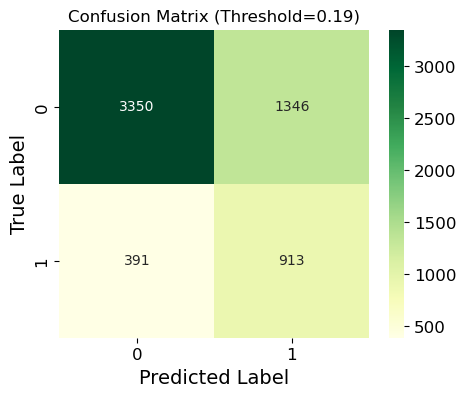

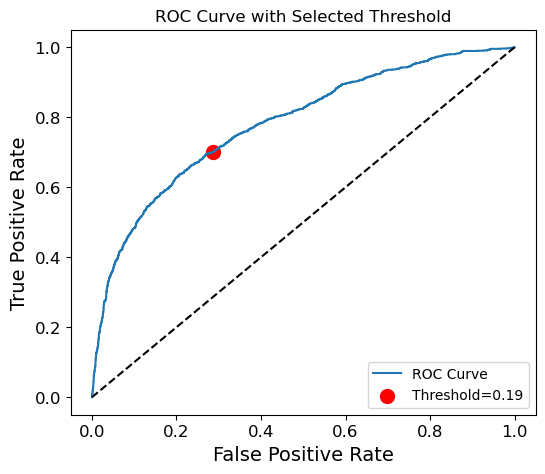

In [45]:
#3.3 Test different shreshold
# if i want to achive 70% of recall, then I need to give 40% Precision
from sklearn.metrics import roc_curve, recall_score, precision_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities
y_prob = final_model_xgb.predict_proba(X_test)[:, 1]

# Get ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Find the threshold that gives TPR (recall) closest to 0.70
target_recall = 0.70
idx = np.argmin(np.abs(tpr - target_recall))
best_threshold = thresholds[idx]

print(f"Threshold that achieves ~70% recall: {best_threshold:.3f}")
print(f"Actual recall at this threshold: {tpr[idx]*100:.2f}%")

# Predict with new threshold
y_pred_custom = (y_prob >= best_threshold).astype(int)

# Evaluate
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn')
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC curve with marked threshold
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], 'k--')
plt.scatter(fpr[idx], tpr[idx], color='red', s=100, label=f'Threshold={best_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Selected Threshold')
plt.legend(loc='lower right')
plt.show()


# 4. Conclusions and Future Work
## Why experiment with these models:
I hope to test out XGBoost because I was curious why it is widely used as the final model in many forecasting applications. 
I compared it with another tree-based model (Random Forest) and a pure regression model (Logistic Regression Classifier) to understand their performance differences.

## Results:
    Logistic Regression Classifier
    The logistic regression model shows no overfitting and is very stable. However, its accuracy is the lowest among the three models because its linear nature cannot effectively capture the non-linear patterns in the data.**
        CV mean accuracy: 81.05% ± 0.41%
        Train accuracy: 81.07%
        Test accuracy: 81.52%
        
    Random Forest Classifier
    The random forest model shows slight overfitting, as the training accuracy is about 4% higher than the test accuracy. With more data, this gap could be reduced. The model remains stable and performs better than logistic regression but slightly worse than XGBoost.**
        Random Forest CV mean accuracy: 81.91% ± 0.39%
        Random Forest Train Accuracy: 85.17%
        Random Forest Test Accuracy: 82.22%
        
    XGBoost Classifier
    The XGBoost model is stable, with very close training and testing accuracy, indicating minimal overfitting. It also achieves the highest accuracy among the three models.
        XGBoost CV mean accuracy: 82.11% ± 0.50%
        XGBoost Train Accuracy: 82.31%
        XGBoost Test Accuracy: 82.35%

** I choose SGBoost because of highest accuracy, no overfitting and stability. **

## Limitations and Threshold Adjustment:

**About 30% of the labels are positive (default payments).All models perform well in predicting non-defaults (negative labels) but are limited in detecting defaults (positive labels).**

If I aim for 70% recall — meaning I want to correctly identify 70% of all default payments — I would need to lower the threshold to 0.187.
At this threshold, precision increase to 40%, which means 40% of the predicted defaults are actually non-defaults, a high cost for practical use.

Therefore, I keep the default 0.5 probability threshold, accepting lower recall but lower precision.

    Threshold achieving ~70% recall: 0.187
    Precision: 40.42%
    Recall: 70.02%

Another way to look at this is in terms of probability: for example, if I only want observations with at least 80% probability to be considered positive. 
## Future work:
### 1. Cluster Customers
In the EDA stage, I examined the two features that show the strongest relationship with the target label.

**The higher the value of PAY_0, the more likely a client is to default.**
**However, the behavior differs between PAY_0 ≤ 1 and PAY_0 > 1:**

    When PAY_0 ≤ 1, clients with higher credit limits have a lower probability of default.
    When PAY_0 > 1, clients with higher credit limits are more likely to default.

**This suggests that clients can be clustered based on PAY_0 into different groups and trained with separate models, allowing the model to better capture their distinct behavioral patterns.**

### 2. Ensemble different models
    I experimented with ensembling models (e.g., combining Random Forest with XGBoost, and Logistic Regression with XGBoost). However, this approach did not improve performance or generalization, so it was not included in the final model.
    
    A possible reason is that Random Forest and XGBoost are too similar, as both are tree-based ensemble methods. If models were trained on different customer clusters (as suggested above) or if more diverse model types were combined, the ensemble might yield better results.
    
    Additionally, a larger dataset could help an ensemble approach perform better, as it would capture a wider variety of data patterns. 